# Bank Customer Churn Prediction Project
This project uses customer data from the "Bank Customer Churn Prediction (DLU Course)" to build a classification solution predicting customer churn. Using XGBoost and LightGBM, we explore how gradient-boosting algorithms can effectively solve this problem. For model optimization, we utilize the HyperOpt library to tune hyperparameters, aiming to maximize the model's accuracy.


Our goal is to predict whether a customer will continue to use their account or close it (i.e., if churn will occur).

## Dataset Description

The dataset includes the following attributes:

- **ID**: Unique identifier for each row
- **Customer ID**: Unique identifier for each customer (this field contains duplicates for different customer records, so it will be removed)
- **Surname**: Customer's last name
- **Credit Score**: Numerical value representing the customer's credit rating
- **Geography**: Country where the customer resides (France, Spain, or Germany)
- **Gender**: Customer's gender (Male or Female)
- **Age**: Customer's age
- **Tenure**: Number of years the customer has been with the bank
- **Balance**: Customer's account balance
- **NumOfProducts**: Number of bank products the customer uses (e.g., savings account, credit card)
- **HasCrCard**: Indicates if the customer has a credit card (1 = yes, 0 = no)
- **IsActiveMember**: Indicates if the customer is an active member (1 = yes, 0 = no)
- **EstimatedSalary**: Estimated salary of the customer
- **Exited**: Indicates if the customer has left the bank (1 = yes, 0 = no)


# Project Structure
- [Data Preprocessing and Feature Engineering](#data-preprocessing-and-feature-engineering)
- [XGBoost Model Training and Evaluation](#xgboost-training)
- [XGBoost Hyperparameter Tuning](#xgboost-hyperparameter-tuning)
- [LightGBM Model Training and Evaluation](#lightGbm-training)
- [LightGBM Hyperparameter Tuning](#lightGbm-hyperparameter-tuning)
- [Best Model Selection for Customer Churn Prediction](#best-model-selection-for-Customer-Churn-Prediction)


# <a id="data-preprocessing-and-feature-engineering">Data Preprocessing</a>


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Function to split data into training and validation sets
def split_train_val(df: pd.DataFrame, target_col: str, test_size: float = 0.2, random_state: int = 42):
    train_df, val_df = train_test_split(df, test_size=test_size, random_state=random_state, stratify=df[target_col])
    return train_df, val_df

# Function to separate features and targets
def separate_inputs_targets(df: pd.DataFrame, input_cols: list, target_col: str):
    inputs = df[input_cols].copy()
    targets = df[target_col].copy()
    return inputs, targets

# Load and preprocess the data
raw_df = pd.read_csv('bank-customer-churn-prediction-dlu/data/train.csv', index_col=0)
train_df, val_df = split_train_val(raw_df, 'Exited')
X_train, train_targets = separate_inputs_targets(train_df, list(train_df.columns)[1:-1], 'Exited')
X_val, val_targets = separate_inputs_targets(val_df, list(val_df.columns)[1:-1], 'Exited')

# Convert categorical columns to "category" data type
cat_features = X_train.select_dtypes(include='object').columns
X_train[cat_features] = X_train[cat_features].astype('category')
X_val[cat_features] = X_val[cat_features].astype('category')

# <a id="xgboost-training">XGBoost Model Training and Evaluation</a> 

In [ ]:
from xgboost import XGBClassifier

# Configure and train the XGBoost classifier
xgb_clf = XGBClassifier(
    max_depth=3,
    n_estimators=10,
    enable_categorical=True,
    use_label_encoder=False,
    missing=np.nan,
    device='cuda'
)
xgb_clf.fit(X_train, train_targets)

In [3]:
# Evaluate with AUROC
from sklearn.metrics import roc_curve, auc

train_pred = xgb_clf.predict_proba(X_train)[:, 1]
val_pred = xgb_clf.predict_proba(X_val)[:, 1]

fpr_train, tpr_train, thresholds_train = roc_curve(train_targets, train_pred)
roc_auc_train = auc(fpr_train, tpr_train)
print(f'Train AUROC: {roc_auc_train:.2f}')

fpr, tpr, thresholds = roc_curve(val_targets, val_pred)
roc_auc = auc(fpr, tpr)
print(f'Val AUROC: {roc_auc:.2f}')

Train AUROC: 0.94
Val AUROC: 0.93


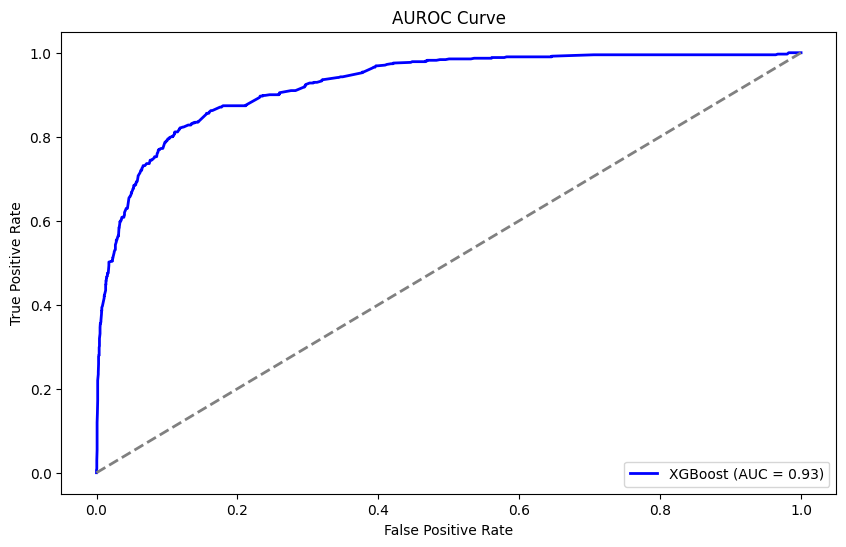

In [4]:
# Plot AUROC curves
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"XGBoost (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUROC Curve")
plt.legend(loc="lower right")
plt.show()

**Conclusion**: The initial XGBoost model achieved high AUROC values on both training and validation sets, indicating strong initial performance. However, hyperparameter tuning is still needed to maximize predictive power and reduce overfitting risk.

# <a id="xgboost-hyperparameter-tuning">XGBoost Hyperparameter Tuning</a> 

In [ ]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import xgboost as xgb

# Define the objective function for hyperparameter optimization
def objective(params):
    clf = xgb.XGBClassifier(
        n_estimators=int(params['n_estimators']),
        learning_rate=params['learning_rate'],
        max_depth=int(params['max_depth']),
        min_child_weight=params['min_child_weight'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        gamma=params['gamma'],
        reg_alpha=params['reg_alpha'],
        reg_lambda=params['reg_lambda'],
        enable_categorical=True,
        use_label_encoder=False,
        missing=np.nan,
        device='cuda',
        early_stopping_rounds=10
    )

    clf.fit(X_train, train_targets, eval_set=[(X_val, val_targets)], verbose=False)
    pred = clf.predict_proba(X_val)[:,1]
    fpr, tpr, thresholds = roc_curve(val_targets, pred)
    roc_auc = auc(fpr, tpr)

    return {'loss': -roc_auc, 'status': STATUS_OK}

# Hyperparameter space
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 500, 25),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'gamma': hp.uniform('gamma', 0, 0.5),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1)
}

# Run the optimization
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20, trials=trials)

In [6]:
print("Best hyperparameters: ", best)

Best hyperparameters:  {'colsample_bytree': 0.8232144476426775, 'gamma': 0.4415347920217806, 'learning_rate': 0.017899001309289946, 'max_depth': 6.0, 'min_child_weight': 10.0, 'n_estimators': 150.0, 'reg_alpha': 0.10016229814788047, 'reg_lambda': 0.7439159126458633, 'subsample': 0.5567805840291067}


## Train the `XGBoostClassifier` model with the best hyperparameters

In [ ]:
# Training the final model with the best hyperparameters
final_clf = xgb.XGBClassifier(
    n_estimators=int(best['n_estimators']),
    learning_rate=best['learning_rate'],
    max_depth=int(best['max_depth']),
    min_child_weight=int(best['min_child_weight']),
    subsample=best['subsample'],
    colsample_bytree=best['colsample_bytree'],
    gamma=best['gamma'],
    reg_alpha=best['reg_alpha'],
    reg_lambda=best['reg_lambda'],
    enable_categorical=True,
    use_label_encoder=False,
    missing=np.nan,
    device='cuda',
)

final_clf.fit(X_train, train_targets)

Accuracy on the validation sample: 0.9365


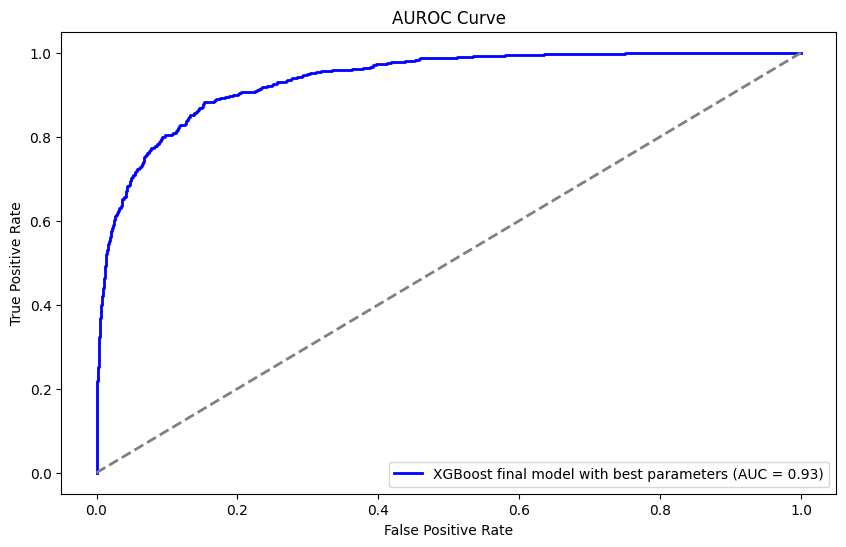

In [8]:
final_pred = final_clf.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(val_targets, final_pred)
final_roc_auc = auc(fpr, tpr)
print("Accuracy on the validation sample: {:.4f}".format(final_roc_auc))

# Plot AUROC curves
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"XGBoost final model with best parameters (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUROC Curve")
plt.legend(loc="lower right")
plt.show()

**Conclusion**: After tuning, the model’s performance on the validation set has been optimized. These hyperparameters provide a more accurate and generalized model, which should reduce overfitting.



# <a id="lightGbm-training">LightGBM Model Training and Evaluation</a> 

In [ ]:
import lightgbm as lgb

# Configure and train the LightGBM classifier
lgb_clf = lgb.LGBMClassifier(
    max_depth=3,
    n_estimators=50,
    learning_rate=0.1,
    cat_feature=[X_train.columns.get_loc(col) for col in X_train.select_dtypes(include='category').columns],
    missing=np.nan
)

lgb_clf.fit(X_train, train_targets, eval_set=[(X_val, val_targets)])

train_pred = lgb_clf.predict_proba(X_train)[:, 1]
val_pred = lgb_clf.predict_proba(X_val)[:, 1]

In [10]:
# Evaluate with AUROC
fpr_train, tpr_train, thresholds_train = roc_curve(train_targets, train_pred)
roc_auc_train = auc(fpr_train, tpr_train)
print(f'Train AUROC: {roc_auc_train:.2f}')

fpr, tpr, thresholds = roc_curve(val_targets, val_pred)
roc_auc = auc(fpr, tpr)
print(f'Val AUROC: {roc_auc:.2f}')

Train AUROC: 0.95
Val AUROC: 0.94


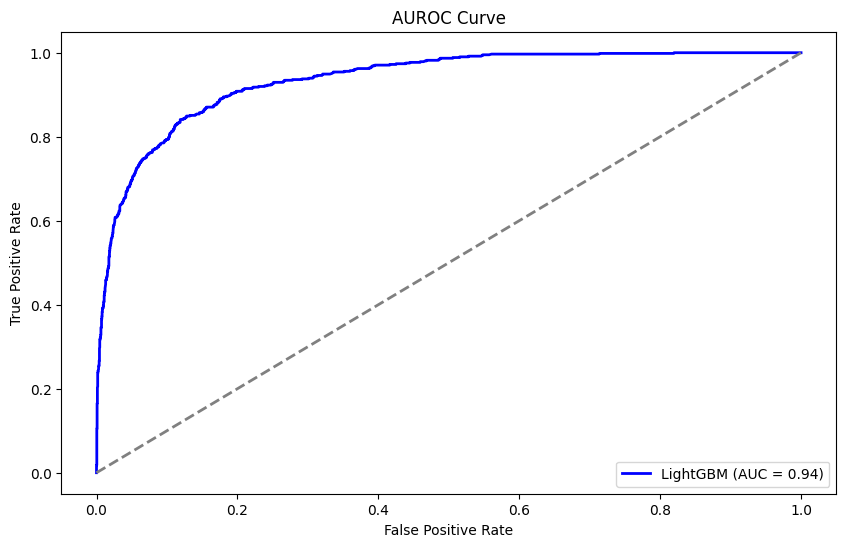

In [11]:
# Plot AUROC curves
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"LightGBM (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUROC Curve")
plt.legend(loc="lower right")
plt.show()

**Conclusion**: LightGBM demonstrates improved results over XGBoost on the validation set. LightGBM's efficient handling of categorical data likely contributed to its effectiveness.

# <a id="lightGbm-hyperparameter-tuning">LightGBM Hyperparameter Tuning</a> 

In [ ]:
def objective(params):
    clf = lgb.LGBMClassifier(
        n_estimators=int(params['n_estimators']),
        learning_rate=params['learning_rate'],
        max_depth=int(params['max_depth']),
        num_leaves=int(params['num_leaves']),
        min_child_weight=params['min_child_weight'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        reg_alpha=params['reg_alpha'],
        reg_lambda=params['reg_lambda'],
        min_split_gain=params['min_split_gain'],
        cat_feature=[X_train.columns.get_loc(col) for col in X_train.select_dtypes(include='category').columns],
        missing=np.nan
    )

    clf.fit(X_train, train_targets, eval_set=[(X_val, val_targets)])
    pred = clf.predict_proba(X_val)[:,1]
    fpr, tpr, thresholds = roc_curve(val_targets, pred)
    roc_auc = auc(fpr, tpr)

    return {'loss': -roc_auc, 'status': STATUS_OK}

# Define hyperparameter space and run optimization
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 500, 25),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'num_leaves': hp.quniform('num_leaves', 20, 150, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'min_split_gain': hp.uniform('min_split_gain', 0, 0.1)
}

trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10, trials=trials)

In [13]:
print("Best hyperparameters for LightGBM: ", best)

Best hyperparameters for LightGBM:  {'colsample_bytree': 0.5048614017558347, 'learning_rate': 0.025313694964775004, 'max_depth': 6.0, 'min_child_weight': 1.0, 'min_split_gain': 0.06388712007589897, 'n_estimators': 200.0, 'num_leaves': 90.0, 'reg_alpha': 0.9799132094844459, 'reg_lambda': 0.8552912575115232, 'subsample': 0.8925019505780933}


## Train the `LightGBM` model with the best hyperparameters

In [ ]:
# Training the final model with the best hyperparameters
final_clf_lgb = lgb.LGBMClassifier(
    n_estimators=int(best['n_estimators']),
    learning_rate=best['learning_rate'],
    max_depth=int(best['max_depth']),
    num_leaves=int(best['num_leaves']),
    min_child_weight=int(best['min_child_weight']),
    subsample=best['subsample'],
    colsample_bytree=best['colsample_bytree'],
    reg_alpha=best['reg_alpha'],
    reg_lambda=best['reg_lambda'],
    min_split_gain=best['min_split_gain'],
    cat_feature=[X_train.columns.get_loc(col) for col in X_train.select_dtypes(include='category').columns],
    missing=np.nan
)

final_clf_lgb.fit(X_train, train_targets, eval_set=[(X_val, val_targets)])

In [ ]:
train_pred = final_clf_lgb.predict_proba(X_train)[:, 1]
val_pred = final_clf_lgb.predict_proba(X_val)[:, 1]

In [16]:
# Evaluate with AUROC
fpr_train, tpr_train, thresholds_train = roc_curve(train_targets, train_pred)
roc_auc_train = auc(fpr_train, tpr_train)
print(f'Train AUROC: {roc_auc_train:.2f}')

fpr, tpr, thresholds = roc_curve(val_targets, val_pred)
roc_auc = auc(fpr, tpr)
print(f'Val AUROC: {roc_auc:.2f}')

Train AUROC: 0.97
Val AUROC: 0.94


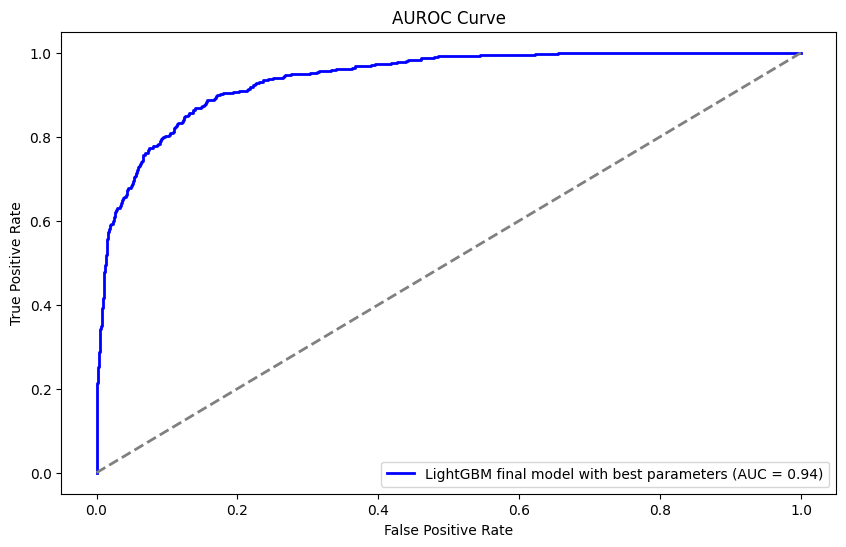

In [17]:
# Plot AUROC curves
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"LightGBM final model with best parameters (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUROC Curve")
plt.legend(loc="lower right")
plt.show()

# <a id="best-model-selection-for-Customer-Churn-Prediction">Best Model Selection for Customer Churn Prediction</a> 

The best results for predicting whether a customer will continue using their account or close it were achieved using the **LightGBM model** with the following optimized hyperparameters:

```python
Best hyperparameters for LightGBM:
{
    'colsample_bytree': 0.7733,
    'learning_rate': 0.0714,
    'max_depth': 3,
    'min_child_weight': 6,
    'min_split_gain': 0.0952,
    'n_estimators': 200,
    'num_leaves': 46,
    'reg_alpha': 0.4257,
    'reg_lambda': 0.0262,
    'subsample': 0.8914
}
